# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [189]:
# import libraries here; add more as necessary
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#imports for Principal Component Analysis (PCA)
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score

#StandardScaler for scaling the data
from sklearn.preprocessing import StandardScaler

#imports for feature imputation
from sklearn.impute import SimpleImputer

#imports for clustering data
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [190]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

In [191]:
#Open Feature Dictionnairy to learn more about the features and responses
feat_Dict = open("Data_Dictionary.md").read()
#print(feat_Dict)
type(feat_Dict)

str

In [192]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
#print the first 20 rows
azdias.head(20)



,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [193]:
#get general information about dataset
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [194]:
#explore descriptive statistics 
azdias.describe()
azdias.shape

(891221, 85)

In [195]:
#print feature attributes
print('Feature attributes in the azduras dataset:')
print('- Datatypes                :', feat_info['type'].unique())
print('- Missing or Unknown values :', feat_info['missing_or_unknown'].unique())
print('-information level         :', feat_info['information_level'].unique())

Feature attributes in the azduras dataset:
- Datatypes                : ['categorical' 'ordinal' 'numeric' 'mixed' 'interval']
- Missing or Unknown values : ['[-1,0]' '[-1,0,9]' '[0]' '[-1]' '[]' '[-1,9]' '[-1,X]' '[XX]' '[-1,XX]']
-information level         : ['person' 'household' 'building' 'microcell_rr4' 'microcell_rr3'
 'postcode' 'region_rr1' 'macrocell_plz8' 'community']


### First insights about dataset

As we can see from the results of `azdias.info()`, `azdias.shape`  the azdias dataframe contains **891221 rows**, **85 columns** in total, some columns have less than 891221 entries. This indicates that those columns contain missing values. The dataset `feat_info` contains in turn definitions for missing or unknown values in addition. Before running the analysis, we thus will have to explore missing values patterns and to clean the dataset to minimize any bias of missing or unknown values.<br>
The dataset consists of **'categorical' 'ordinal' 'numeric' 'mixed' 'interval' data**. As we can see from the results of `azdias.describe()` the features are variying in ther minimum and maximum values. Before running the analysis, we will thus have to standardize the data.  <br>

**Next steps to perform before running the analysis:** <br>
- explore missing / unknown data and clean the dataset
- apply feature scaling

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [196]:
# Identify missing or unknown data values and convert them to NaNs.

#step 1: Get total count of naturally missing data in azdias
naNatural=azdias.isnull().sum().sum()
 
#print total count of naturally missing data in azdias 
vTotal= 891221*85
print("Total count of naturally missing values in the azdias dataset: ", naNatural)
print("Percentage of naturally missing values in the azdias dataset :", "{0:.0%}".format(naNatural/vTotal))

Total count of naturally missing values in the azdias dataset:  4896838
Percentage of naturally missing values in the azdias dataset : 6%


Count of missing values by column in the azdias dataset:  AGER_TYP             0
SEMIO_SOZ            0
SEMIO_FAM            0
SEMIO_REL            0
SEMIO_MAT            0
                 ...  
KBA05_ANTG4     133324
KBA05_ANTG3     133324
KBA05_ANTG2     133324
KBA05_ANTG1     133324
KK_KUNDENTYP    584612
Length: 85, dtype: int64


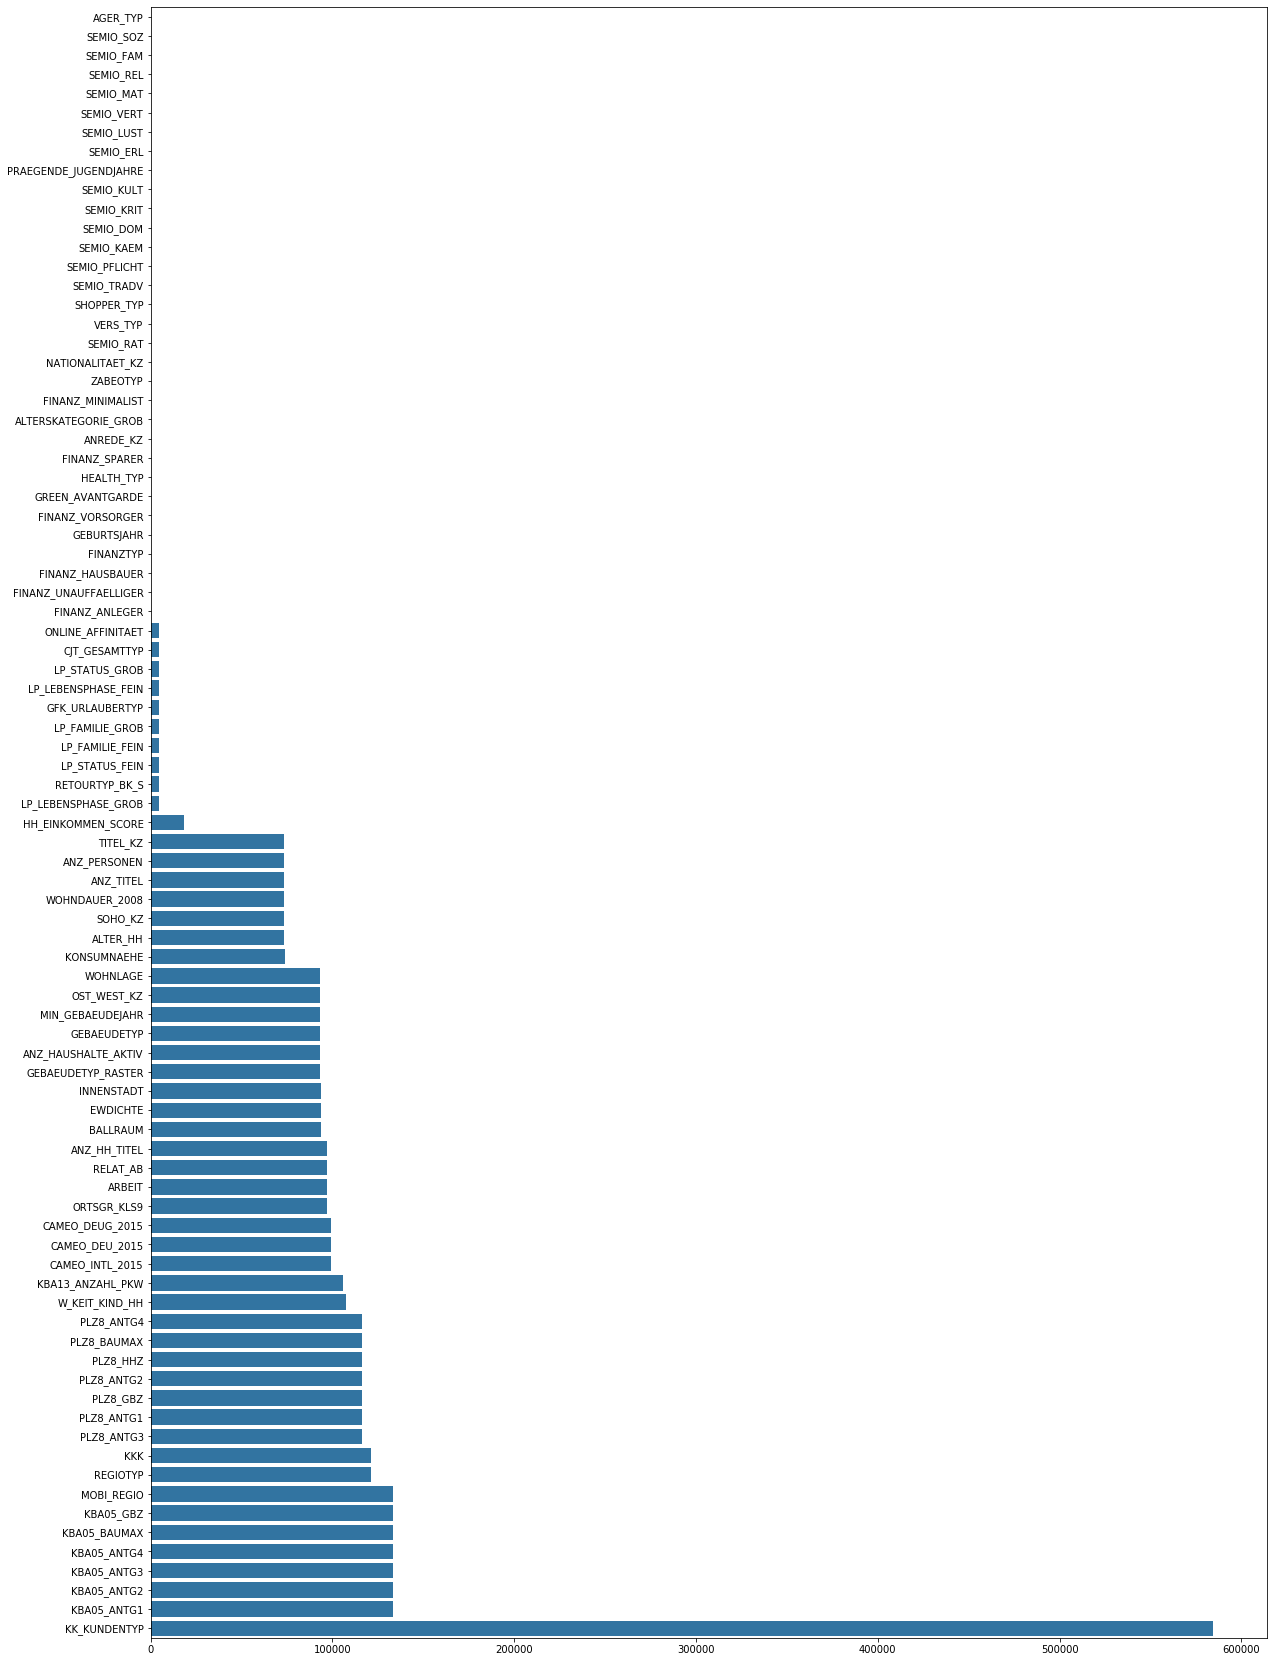

In [197]:
#get total count of naturally missing data by column
naColumn = azdias.isnull().sum().sort_values()
print("Count of missing values by column in the azdias dataset: ", naColumn)

#plot total count of naturally missing data by column to view which columns are affected in particular 
baseColor = sns.color_palette()[0]
xlim=(891221)
plt.figure(figsize=(20,30))
sns.barplot(naColumn, naColumn.index.values, color = baseColor)

More than have of the features contain missing values naturally. The feature **"KK_KUNDENTYP"** contains already naturally more than have missing values.


In [198]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [199]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [200]:
# create a dictionnairy with missing values

nanDict = {'nan': feat_info['missing_or_unknown'] \
             .astype(str).str.replace('[','').astype(str).str.replace(']','').astype(str).str.split(',').values}
#create a dataframe containing nanValues from nanDict and attributes from feat_info
nanInfo = pd.DataFrame(nanDict, index = feat_info['attribute'].values)


In [201]:
azdias['AGER_TYP'][2] #check value in azdias dataset, which should be declared as 'nan'

-1

In [202]:
#function to handle data type integer 
def check_int(value):
  try:
    int(value)
    return True
  except ValueError:
    return False

In [203]:
#declare as nan in nanInfo

nanInfo['nan'] = nanInfo.apply(lambda x: [int(nan) if check_int(nan) == True
                                                    else nan for nan in x[0]], axis=1)

In [204]:
print(nanInfo)
nanInfo.info()

                             nan
AGER_TYP                 [-1, 0]
ALTERSKATEGORIE_GROB  [-1, 0, 9]
ANREDE_KZ                [-1, 0]
CJT_GESAMTTYP                [0]
FINANZ_MINIMALIST           [-1]
...                          ...
PLZ8_HHZ                    [-1]
PLZ8_GBZ                    [-1]
ARBEIT                   [-1, 9]
ORTSGR_KLS9              [-1, 0]
RELAT_AB                 [-1, 9]

[85 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, AGER_TYP to RELAT_AB
Data columns (total 1 columns):
nan    85 non-null object
dtypes: object(1)
memory usage: 1.3+ KB


In [205]:
#set values as 'nan' in azdias dataset according to the nan Info from the feat_info dataset
for c in azdias.columns:
    # Get index 0 of missing_vals.loc[column] to get actual array
    azdias[c] = azdias[c].replace(nanInfo.loc[c][0], np.nan)

In [206]:
azdias['AGER_TYP'][2] #check if the value is now defined as 'nan'

nan

In [207]:
azdias.head() #check the dataset 

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [208]:
#total count of missing values
naTotal=azdias.isnull().sum().sum()
 
#total count of values in azdias dataset
vTotal= 891221*85
print("Total count of missing values in the azdias dataset: ", naTotal)
print("Percentage of missing values in the azdias dataset :", "{0:.0%}".format(naTotal/vTotal))


Total count of missing values in the azdias dataset:  8373929
Percentage of missing values in the azdias dataset : 11%


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

Count of missing values by column in the azdias dataset:  ZABEOTYP              0
SEMIO_TRADV           0
SEMIO_PFLICHT         0
SEMIO_KAEM            0
SEMIO_DOM             0
                  ...  
GEBURTSJAHR      392318
KBA05_BAUMAX     476524
KK_KUNDENTYP     584612
AGER_TYP         685843
TITEL_KZ         889061
Length: 85, dtype: int64


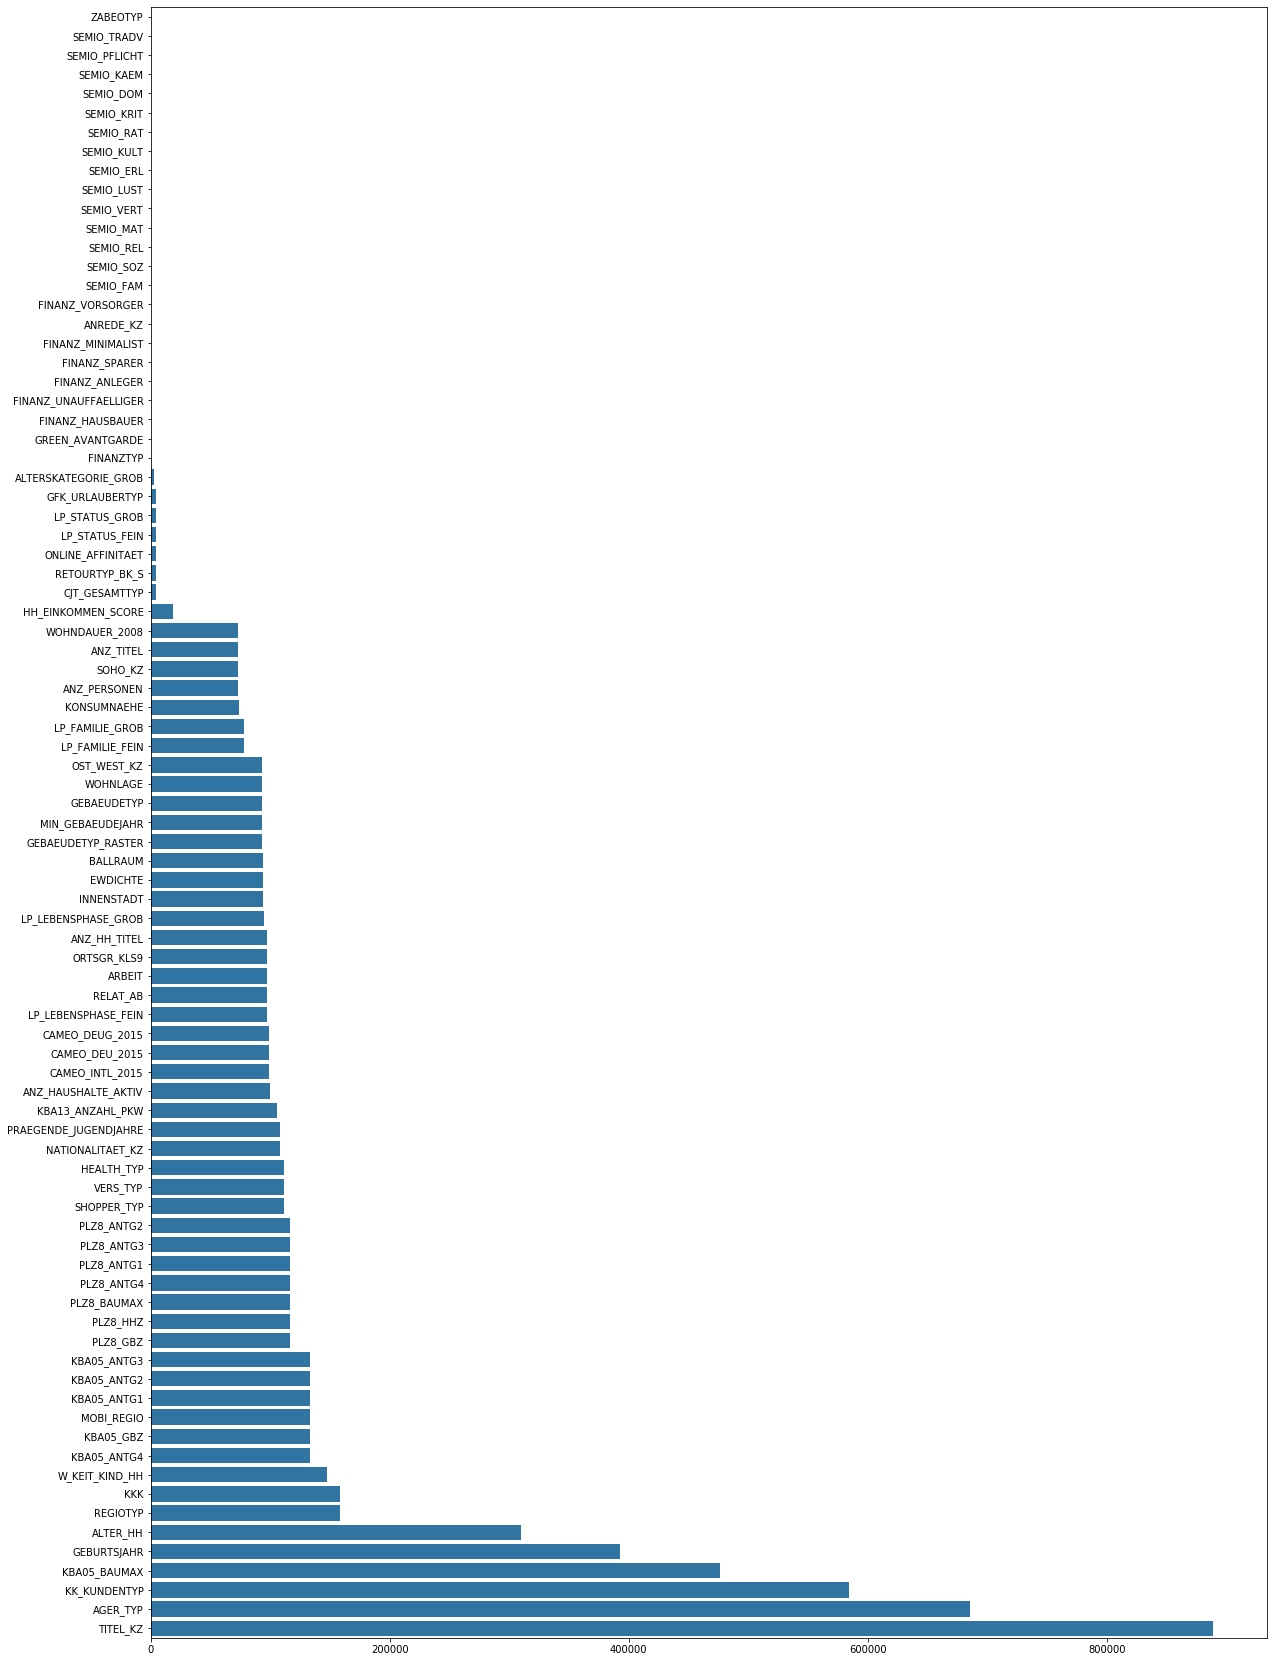

In [211]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

#get total count of naturally missing data by column
naColumn = azdias.isnull().sum().sort_values()
print("Count of missing values by column in the azdias dataset: ", naColumn)

#plot total count of naturally missing data by column to view which columns are affected in particular 
baseColor = sns.color_palette()[0]
xlim=(891221)
plt.figure(figsize=(20,30))
sns.barplot(naColumn, naColumn.index.values, color = baseColor)

In [214]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdiasNan = azdias.drop(['TITEL_KZ', 'AGER_TYP','KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis=1)

azdiasNan.shape


(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column (= Feature)

**Naturally**, already **6% (total count = 4896838) are missing values** in the azdias dataset. More than have of the features contain missing values naturally. The feature **"KK_KUNDENTYP"** contains already **naturally more than half** missing values. <br>The feat_info dataset contains "nan" (= missing / unknown) values for each feature by definition. We compared the values of each feature of the azdias dataset with the "nan" values for the feature declared in the feat_info dataset. We set the value in the azdias dataset to "nan", if it equaled the 'nan" definition for the feature. <br>After performing this cleaning procedure, the percentage of missing values in the azdias dataset **raise to 11% (Total count = 8373929)**. The features **'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'**- ranked from most to less- **contain >= 20% missing values**. We therefore excluded the features from the dataset. Side note: After cleaning, the features Titel_KZ and AGER_TYP contain comparable much more missing values than before, whereas the number of missing values for KK_KUNDENTYP almost stayed the same. Performing the cleaning procedure is thus very important to exclude any bias on the dataset. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [216]:
# Get count of missing data for all rows.
nanperRows= azdiasNan.isnull().sum(axis=1)
print(nanperRows)  #check output 
nanperRows.describe().round(2) # print descriptive data

0         43
1          0
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64


count    891221.00
mean          5.65
std          13.23
min           0.00
25%           0.00
50%           0.00
75%           3.00
max          49.00
dtype: float64

The high standard deviation of 13.43 already indicates, that the missing values show a great variation among the rows. Half of the rows do not contain any missing values whereas the upper percentile of the rows varies between 3 to maximum 49 missing values. Let's have a closer look on the distribution in a plot.

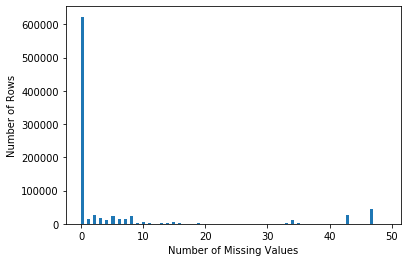

In [217]:
#plot the number of missing values against the number of rows, containing the missing values
plt.hist(nanperRows, bins=100)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

The plot illustrates that most of the rows contain less than 10 missing values and just view rows contain > 30 missing values. Let's explore the impact of removing the rows with > 30 missing values. We will therefore create a new dataset which just includes rows with <= 30 missing values and compare it to the dataset including rows >30 missing values.

In [218]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
nanRowstoInclude=nanperRows[nanperRows<=30]
nanRowstoExclude=nanperRows[nanperRows>30]

print('rows with > 30 missing values:  ', nanRowstoExclude.shape[0], ' percentage of total rows= : ', 
      np.round(nanRowstoExclude.shape[0]*100/nanperRows.shape[0],2), '%')
print('rows with <=30 missing values: ', nanRowstoInclude.shape[0], ' percentage of total rows= : ', 
      np.round(nanRowstoInclude.shape[0]*100/nanperRows.shape[0],2), '%')
      #np.round(nanRows30.shape[0]*100/nanRows.shape[0],2), '% of all data')

rows with > 30 missing values:   93154  percentage of total rows= :  10.45 %
rows with <=30 missing values:  798067  percentage of total rows= :  89.55 %


In [219]:
# Save the dataset with rows >30 missing values for later analysis 
azdiasRowsNan = azdiasNan.iloc[nanRowstoExclude.index]

In [220]:
# Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.
#function to compare value distribution between subesets
def compare_distribution(column):
    fig = plt.figure(figsize=(14,4))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('dataset containing rows <= 30 missing values')
    sns.countplot(azdiasNan.loc[nanRowstoInclude.index,column], palette="Blues")

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('dataset containing rows > 30 missing values')
    sns.countplot(azdias.loc[nanRowstoExclude.index,column], palette="Blues");

    fig.suptitle(column)
    plt.show()

In [221]:
print(feat_info[10:20])

              attribute information_level         type missing_or_unknown
10            FINANZTYP            person  categorical               [-1]
11          GEBURTSJAHR            person      numeric                [0]
12      GFK_URLAUBERTYP            person  categorical                 []
13     GREEN_AVANTGARDE            person  categorical                 []
14           HEALTH_TYP            person      ordinal             [-1,0]
15  LP_LEBENSPHASE_FEIN            person        mixed                [0]
16  LP_LEBENSPHASE_GROB            person        mixed                [0]
17      LP_FAMILIE_FEIN            person  categorical                [0]
18      LP_FAMILIE_GROB            person  categorical                [0]
19       LP_STATUS_FEIN            person  categorical                [0]


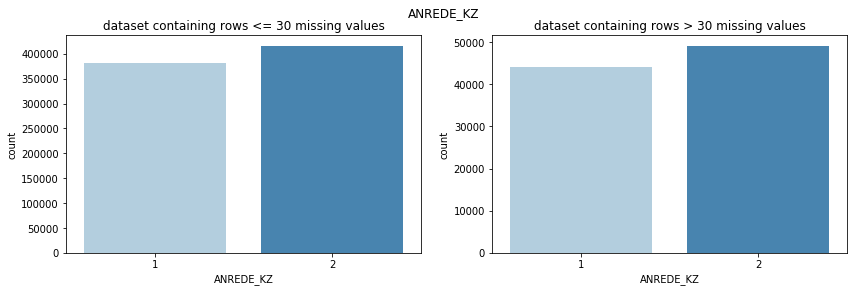

In [222]:
compare_distribution('ANREDE_KZ')

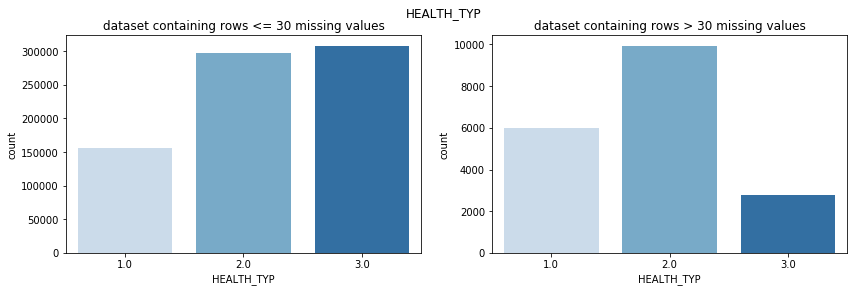

In [223]:
compare_distribution('HEALTH_TYP')

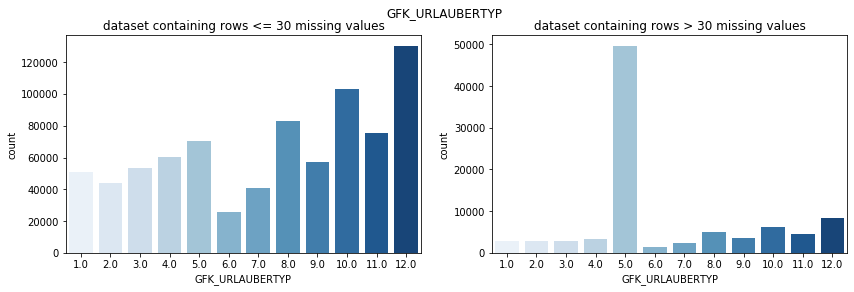

In [224]:
compare_distribution('GFK_URLAUBERTYP')

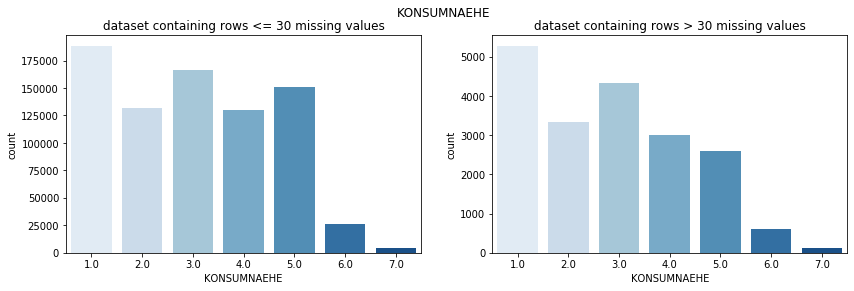

In [225]:
compare_distribution('KONSUMNAEHE')

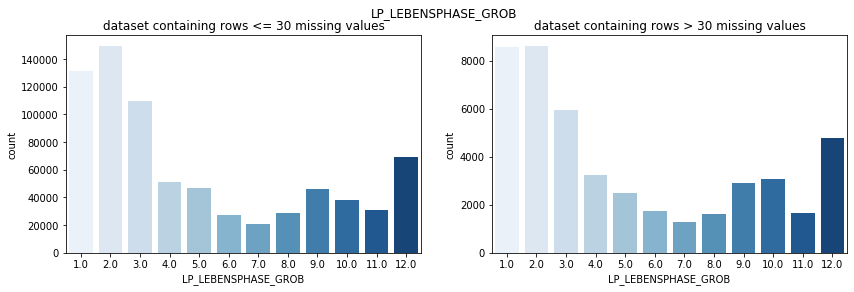

In [226]:
compare_distribution('LP_LEBENSPHASE_GROB')

In [227]:
# Drop the rows with >30 missing values

print('row count before dropping rows with >30 missing values: ', azdiasNan.shape[0])

azdiasNan = azdiasNan[~azdiasNan.index.isin(nanRowstoExclude.index)]

print('row count after dropping rows with >30 missing values:  ', azdiasNan.shape[0])

row count before dropping rows with >30 missing values:  891221
row count after dropping rows with >30 missing values:   798067


#### Discussion 1.1.3: Assess Missing Data in Each Row

The 891221 rows vary between 0 to 49 missing values, whereas 89.55% contain less than 30 missing values and just 10.45% contain more than 30 missing values. We splitted the dataset into two subsets: a dataset with >30 missing values and a dataset with <=30 missing values and compared its distributions for 5 features (as an example) to see whether there is a difference in responding. The responses to gender (=ANREDE_KZ) show similar distributions in both datasets. The datasets slighty varied in their responses to the life stage (= "LP_LEBENSPHASE_GROB"). People with low-income and average earners of higher age from multiperson households are comparably slightly more represented in the dataset with >30 missing values. The two datasets differed as well in their response pattern with regard to the the features vacation habits (='GFK_URLAUBERTYP'), healthy typology (='HEALTH_TYP') and the distance from building to point of sale (PoS)(='KONSUMNAEHE'). This indicates that rows with many missing values differ in their responses and may bring in bias. We will therefore drop those rows for further analysis. As the different sample sizes of the datasets could also affect the responses, we saved the dataset containing the rows with > 30 missing values as backup (=dataset: azdiasRowsNan).

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [228]:
# How many features are there of each data type?
#get the count for the azdias data type 
feat_info['type'].value_counts()


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [229]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categoryColumns = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values
print(categoryColumns)

['AGER_TYP' 'ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN'
 'LP_STATUS_GROB' 'NATIONALITAET_KZ' 'SHOPPER_TYP' 'SOHO_KZ' 'TITEL_KZ'
 'VERS_TYP' 'ZABEOTYP' 'KK_KUNDENTYP' 'GEBAEUDETYP' 'OST_WEST_KZ'
 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015']


In [230]:
#drop removed features from feat_info
feat_info = feat_info[~feat_info['attribute'].isin(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR'])]

'Feat_info' still contains features (like 'AGER_TYP') which we removed before. We therefore have to remove those features before re-encoding to not run into a Key error when comparing the keys of 'feat_info' with the keys in the 'azdiasNan' dataset.

In [231]:
#repeat the assessment of categorial variables, to remove dropped features
categoryColumns = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].values
print(categoryColumns)

['ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN'
 'LP_STATUS_GROB' 'NATIONALITAET_KZ' 'SHOPPER_TYP' 'SOHO_KZ' 'VERS_TYP'
 'ZABEOTYP' 'GEBAEUDETYP' 'OST_WEST_KZ' 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015']


In [232]:
feat_info = feat_info[~feat_info['attribute'].isin(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR'])]
print(feat_info)
                      

               attribute information_level         type missing_or_unknown
1   ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2              ANREDE_KZ            person  categorical             [-1,0]
3          CJT_GESAMTTYP            person  categorical                [0]
4      FINANZ_MINIMALIST            person      ordinal               [-1]
5          FINANZ_SPARER            person      ordinal               [-1]
..                   ...               ...          ...                ...
80              PLZ8_HHZ    macrocell_plz8      ordinal               [-1]
81              PLZ8_GBZ    macrocell_plz8      ordinal               [-1]
82                ARBEIT         community      ordinal             [-1,9]
83           ORTSGR_KLS9         community      ordinal             [-1,0]
84              RELAT_AB         community      ordinal             [-1,9]

[80 rows x 4 columns]


In [233]:
# Re-encode categorical variable(s) to be kept in the analysis.
#detect binary / multilevel variables in dataset  
categoryBinary = []
categoryMulti=[]
for c in categoryColumns:
    if azdiasNan[c].nunique() <=2:
        categoryBinary.append(c)
    else:
        categoryMulti.append(c)
print('binary variables:     ', categoryBinary)
print('multilevel variables: ', categoryMulti)

binary variables:      ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
multilevel variables:  ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [234]:
#view binary variables to select 
for v in categoryBinary:
    print(azdiasNan[v].value_counts())

2    416181
1    381886
Name: ANREDE_KZ, dtype: int64
0    622842
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791350
1.0      6717
Name: SOHO_KZ, dtype: int64
2.0    394238
1.0    367103
Name: VERS_TYP, dtype: int64
W    629525
O    168542
Name: OST_WEST_KZ, dtype: int64


In [235]:
# replace values "2,1" "0,1" "2.0, 1.0" "O, W" with "2.0,1.0"
azdiasNan['OST_WEST_KZ'].replace(['W','O'], [1.0,2.0], inplace=True)
azdiasNan['ANREDE_KZ'].replace([2,1], [2.0,1.0], inplace=True)
azdiasNan['GREEN_AVANTGARDE'].replace([0,1], [1.0,2.0], inplace=True)
azdiasNan['SOHO_KZ'].replace([0.0,1.0], [1.0,2.0], inplace=True)

In [236]:
azdiasNan.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [237]:
#perform One hot coding on multilevel categorial variables
azdiasNan = pd.get_dummies(azdiasNan, columns=categoryMulti)

In [238]:
azdiasNan.head() # check one hot coding

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2.0,1,5,2,5,4,5,1.0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2.0,1,4,1,2,3,5,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2.0,4,2,5,2,1,2,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1.0,4,3,4,1,3,2,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2.0,3,1,5,2,2,5,1.0,3.0,...,0,0,0,1,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

We performed One-hot encoding on multilevel categorial variables and replaced the type string binary variable with numerical values. In addition we replaced type numerical binary variables with the values 1.0/ 2.0, to follow one schema for further analysis. There was no need to drop any variable, as we were able to scale all categorial variables.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [57]:
print(feat_Dict) # print feat_Dict for details

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

In [239]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdiasNan[['PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE
1,14.0
2,15.0
3,8.0
4,8.0
5,3.0


In [240]:
#create dictionnairy containing decade information
decades={
1:[1,2], 2:[3,4], 3:[5,6,7], 4:[8,9], 5:[10,11,12, 13], 6:[14,15]
}

#create dictionnairy containing movement information
movement={
 1:[1,3,5,8,10,12,14] , 2:[2,4,6,7,9,11,13,15] 
}

In [241]:
#write function to map the decades information to the variable "PRAEGENDE_JUGENDJAHRE"
def scale_decades(x):
    try:
        for key, array in decades.items():
            if x in array:
                return key
    except ValueError:
        return np.nan

In [242]:
#write function to map the decades information to the variable "PRAEGENDE_JUGENDJAHRE"
def scale_movement(x):
    try:
        for key, array in movement.items():
            if x in array:
                return key
    except ValueError:
        return np.nan

In [243]:
#apply the functions to generate 2 new variables containing decades / movement information seperately 
azdiasNan['PRAEGENDE_JUGENDJAHRE_MOV']=azdiasNan['PRAEGENDE_JUGENDJAHRE'].apply(scale_movement)
azdiasNan['PRAEGENDE_JUGENDJAHRE_DEC']=azdiasNan['PRAEGENDE_JUGENDJAHRE'].apply(scale_decades)

In [244]:
# Drop original PRAEGENDE_JUGENDJAHRE variable, which will not be used 
azdiasNan = azdiasNan.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)

In [245]:
azdiasNan.head() # check the generated variables

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOV,PRAEGENDE_JUGENDJAHRE_DEC
1,1.0,2.0,1,5,2,5,4,5,1.0,3.0,...,0,0,0,0,0,0,0,0,1.0,6.0
2,3.0,2.0,1,4,1,2,3,5,2.0,3.0,...,0,0,0,0,0,0,0,0,2.0,6.0
3,4.0,2.0,4,2,5,2,1,2,1.0,2.0,...,0,0,0,0,0,0,0,0,1.0,4.0
4,3.0,1.0,4,3,4,1,3,2,1.0,3.0,...,0,0,0,0,0,0,0,0,1.0,4.0
5,1.0,2.0,3,1,5,2,2,5,1.0,3.0,...,0,1,0,0,0,0,0,0,1.0,2.0


In [246]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdiasNan[['CAMEO_INTL_2015']].head()

,CAMEO_INTL_2015
1,51
2,24
3,12
4,43
5,54


Note: datatype is string, not int. Format to int while scaling

In [247]:
#write function to map the wealth information to the variable "CAMEO_INTL_2015"
def scale_wealth(x):
    if pd.isnull(x): #handle nans first to not rescale them
        return np.nan
    else:
        return int(str(x)[0]) #check the string on position zero (=tens place) and return it as int


In [248]:
#write function to map the lifestage information to the variable "CAMEO_INTL_2015"
def scale_lifestage(x):
    if pd.isnull(x): #handle nans first to not rescale them
        return np.nan
    else:
        return int(str(x)[1]) #check the string on position 1 (=ones place) and return it as int


In [249]:
azdiasNan['CAMEO_INTL_2015_WEALTH']=azdiasNan['CAMEO_INTL_2015'].apply(scale_wealth)
azdiasNan['CAMEO_INTL_2015_LIFESTAGE']=azdiasNan['CAMEO_INTL_2015'].apply(scale_lifestage)

In [250]:
azdiasNan.head() #check the just created variables

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOV,PRAEGENDE_JUGENDJAHRE_DEC,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,1.0,2.0,1,5,2,5,4,5,1.0,3.0,...,0,0,0,0,0,0,1.0,6.0,5.0,1.0
2,3.0,2.0,1,4,1,2,3,5,2.0,3.0,...,0,0,0,0,0,0,2.0,6.0,2.0,4.0
3,4.0,2.0,4,2,5,2,1,2,1.0,2.0,...,0,0,0,0,0,0,1.0,4.0,1.0,2.0
4,3.0,1.0,4,3,4,1,3,2,1.0,3.0,...,0,0,0,0,0,0,1.0,4.0,4.0,3.0
5,1.0,2.0,3,1,5,2,2,5,1.0,3.0,...,0,0,0,0,0,0,1.0,2.0,5.0,4.0


In [251]:
# Drop original CAMEO_INTL_2015 variable, which will not be used 
azdiasNan = azdiasNan.drop(['CAMEO_INTL_2015'], axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Both, the "CAMEO_INTL_2015" and the "PRAEGENDE_JUGENDJAHRE" mixed variables were each split into two variables, containing the mixed information seperately. The original variables were dropped, as they do not contain any additional information.  


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [252]:
#drop not engineered mixed type features from the dataset
#get mixedColumns
mixedColumns = feat_info.loc[feat_info['type'] == 'mixed', 'attribute'].values
print(mixedColumns)

['LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'PRAEGENDE_JUGENDJAHRE'
 'WOHNLAGE' 'CAMEO_INTL_2015' 'PLZ8_BAUMAX']


In [253]:
#drop not engineered mixed type columns from azdiasNan 
azdiasNan = azdiasNan.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1)


In [254]:
# check that the dataset just contains unique columns and numerical data for further analysis
np.unique(azdiasNan.dtypes.values)
azdiasNan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798067 entries, 1 to 891220
Columns: 192 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFESTAGE
dtypes: float64(44), int64(20), uint8(128)
memory usage: 493.2 MB


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [255]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    #set values as 'nan' in azdias dataset according to the nan Info from the feat_info dataset
    for c in df.columns:
    # Get index 0 of missing_vals.loc[column] to get actual array
        df[c] = df[c].replace(nanInfo.loc[c][0], np.nan)
    
    # remove selected columns ...
    df = df.drop(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis=1)
   
    #detect rows with many nans (=>30 missing values)
    nanperRows= df.isnull().sum(axis=1)
    nanRowstoExclude=nanperRows[nanperRows>30]
    
    #remove rows with > 30 missing values
    df30inRowNan = df.iloc[nanRowstoExclude.index]
    df = df[~df.index.isin(nanRowstoExclude.index)]
    
    # select, re-encode, and engineer column values.
    # replace values "2,1" "0,1" "2.0, 1.0" "O, W" with "2.0,1.0"
    df['OST_WEST_KZ'].replace(['W','O'], [1.0,2.0], inplace=True)
    df['ANREDE_KZ'].replace([2,1], [2.0,1.0], inplace=True)
    df['GREEN_AVANTGARDE'].replace([0,1], [1.0,2.0], inplace=True)
    df['SOHO_KZ'].replace([0.0,1.0], [1.0,2.0], inplace=True)
    #perform One hot coding on multilevel categorial variables
    df = pd.get_dummies(df, columns=categoryMulti)
    
    #apply the functions to generate 2 new variables containing decades / movement information seperately 
    df['PRAEGENDE_JUGENDJAHRE_MOV']=df['PRAEGENDE_JUGENDJAHRE'].apply(scale_movement)
    df['PRAEGENDE_JUGENDJAHRE_DEC']=df['PRAEGENDE_JUGENDJAHRE'].apply(scale_decades)
    # Drop original PRAEGENDE_JUGENDJAHRE variable, which will not be used 
    df = df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
    df['CAMEO_INTL_2015_WEALTH']=df['CAMEO_INTL_2015'].apply(scale_wealth)
    df['CAMEO_INTL_2015_LIFESTAGE']=df['CAMEO_INTL_2015'].apply(scale_lifestage)
    # Drop original CAMEO_INTL_2015 variable, which will not be used 
    df = df.drop(['CAMEO_INTL_2015'], axis=1)
    #drop other not engineered mixed type columns from df 
    df = df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','WOHNLAGE', 'PLZ8_BAUMAX'], axis=1)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [256]:
# Impute nans
imputer = SimpleImputer(strategy='most_frequent')
azdiasNanImputed = imputer.fit_transform(azdiasNan)

In [257]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaledFeatures = scaler.fit_transform(azdiasNanImputed)


### Discussion 2.1: Apply Feature Scaling
More than half of the columns contain missing values. To not loose those variables, I decided to apply simple feature imputation, strategy "most frequent", because it performs well on categorial data and is computionally fast(1, 2). I would have preferred to apply multivariate impution because it is more accurate in its predictions, as the value prediction is a regression function of features in the dataset. My computer could not handle the calculation, that is why I preferred to apply the simple Impution method. <br>
As suggested, I applied the StandardScaler to scale each feature to mean 0 and standard deviation 1. <br>
**References** <br>
(1) https://scikit-learn.org/stable/modules/impute.html <br>
(2) https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [258]:
# Apply PCA to the data.
pca = PCA()
pcaFeatures = pca.fit_transform(scaledFeatures)

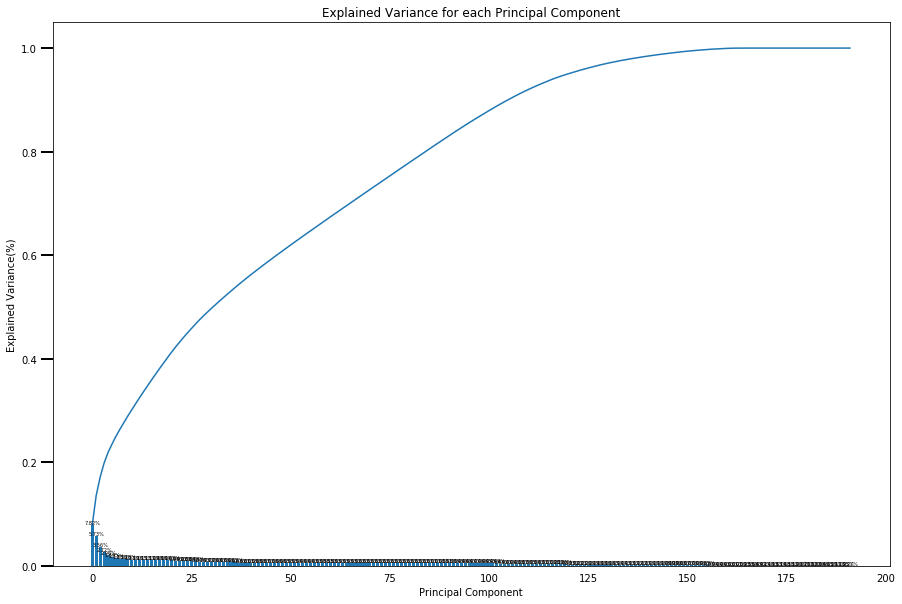

In [259]:
# Investigate the variance accounted for by each principal component.
#Function to plot the variance explained for each principal component

def scree_plot(pca):
    
    numComponents = len(pca.explained_variance_ratio_)
    ind = np.arange(numComponents)
    values = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cumvalues = np.cumsum(values)
    ax.bar(ind, values)
    ax.plot(ind, cumvalues)
    for i in range(numComponents):
        ax.annotate(r"%s%%" % ((str(values[i]*100)[:4])), (ind[i]+0.2, values[i]), va="bottom", ha="center", fontsize=5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Explained Variance(%)")
    plt.title('Explained Variance for each Principal Component')
    

scree_plot(pca)

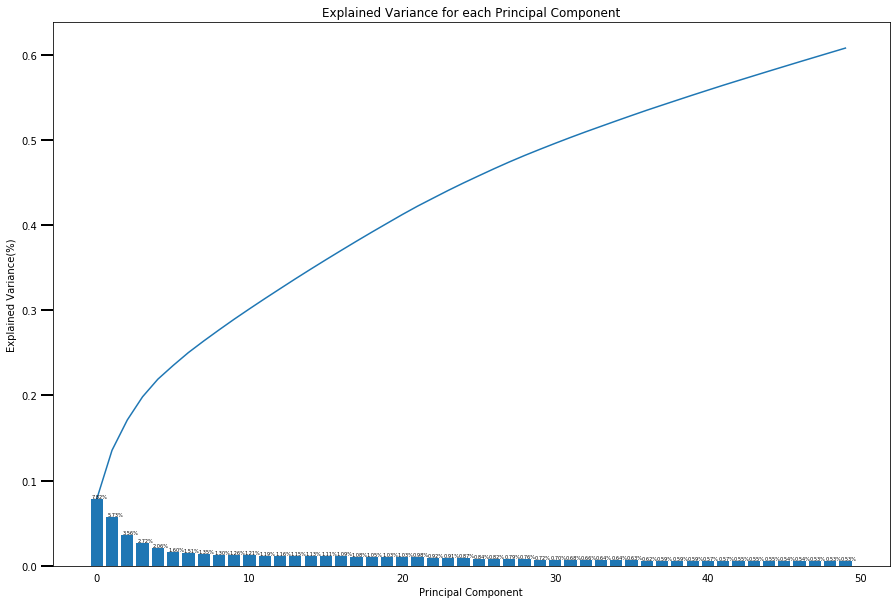

In [260]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(50)
pcaFeatures = pca.fit_transform(scaledFeatures)

scree_plot(pca)

In [261]:
#compare the original with the pca shape to check the number of components 
print("original shape:   ", scaledFeatures.shape)
print("transformed shape:", pcaFeatures.shape)

original shape:    (798067, 192)
transformed shape: (798067, 50)


### Discussion 2.2: Perform Dimensionality Reduction

I applied PCA (1) without any component limitiations to view the trend in variability. the first 100 components explain close to 90% of the variance, while the first 50 components explain more than 60% of the variance.  As half of the compoenents explain just 30% less variance, I decided to continue with 50 components. 

**References**
(1) https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [263]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
#Function to plot the variable associated with each pca component to understant the weighting of the components
def plot_component(data, pca, nComponent):
    '''Plot the features with the most absolute variance for given pca component '''
    component = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[nComponent-1]
    component.sort_values(ascending=False, inplace=True)
    component = pd.concat([component.head(5), component.tail(5)])
    
    component.plot(kind='bar', title='Component ' + str(nComponent))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()
    

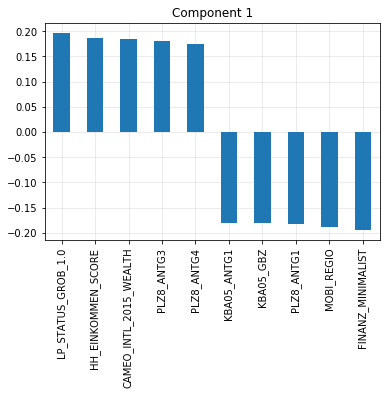

In [264]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_component(azdiasNan, pca, 1)

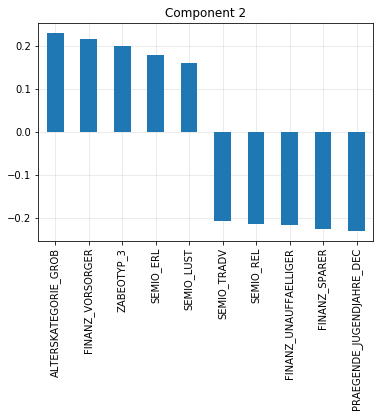

In [265]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_component(azdiasNan, pca, 2)


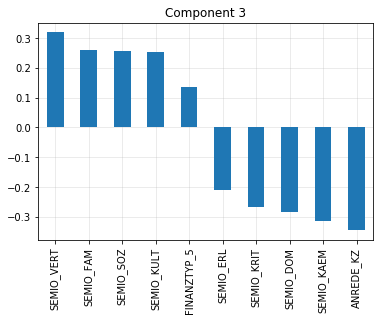

In [266]:
plot_component(azdiasNan, pca, 3)

### Discussion 2.3: Interpret Principal Components

**COMPONENT 1** <br>
The first component seems to deal with the financial and living situation.<br>
LP_STATUS_GROB, HH_EINKOMMEN_SCORE, CAMEO_INTL_2015_WEALTH, PLZ8_ANTG3, PLZ8_ATNG4 1 show a positive correlation with this component: a low income, and > 6 family houses in the surrounding are associated with the component. It is in turn negative associated with few family houses in the surrounding, Movement patterns and low financial interest.<br>

**COMPONENT 2** <br>
The second component seems to deal with age and lifestyle (financial / movement).<br>
It is positively correlated with ALTERSKATEGORIE_GROB (age), FINANZ_VORSORGER (be prepared), ZABEOTYP_3 (Energy consumption, fair supplied), SEMIO_ERL (event-oriented), SEMIO_ERL(sensual minded).In turn it is negatively associated with PRAEGENDE_JUGENDJAHRE_DEC (Decade of movement of person's youth (highest is 90s), FINANZ_SPARER: money-saver), FINANZ_UNAUFFAELLIGER: inconspicuous (financial). <br>

**COMPONENT 3** <br>
The third component seems to deal with personal traits. <br> It is positively correlated with Personality typologies (Semio_Vert: dreamful, Semio_Fam= family-minded, Semio_Soz= socially minded, Semio_Kult: cultural minded). It shows negative asssociations with Gender (ANREDE_KZ), and a combative (SEMIO_KAEM), dominant (SEMIO_DOM) or critcial (Semio_Krit) or event oriented (SEMIO_ERL) personality.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [267]:
# Calculation without sample did not end after 3 hours - Create sample to reduce computation time
pcaFeaturesSelection = pcaFeatures[np.random.choice(pcaFeatures.shape[0], \
                                                    int(pcaFeatures.shape[0]*0.2), replace=False)]

In [268]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
sse = [] # Sum of Squared errors
kMeans= np.arange(1, 15)
startTime = time.time()
print(startTime)
for k in kMeans:
    model=KMeans(k).fit(pcaFeaturesSelection)
    score=np.abs(model.score(pcaFeaturesSelection))
    sse.append(score)

1586802040.228655


Run time: 4.95 min


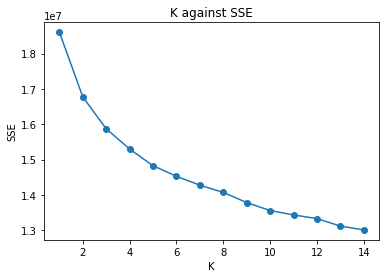

In [269]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(kMeans, sse, linestyle='-', marker='o')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('K against SSE')

print("Run time: %s min" % np.round(((time.time() - startTime)/60),2))

In [270]:
sse = []
kMeans= np.arange(1, 25)
startTime = time.time()
print(startTime)
for k in kMeans:
    model=KMeans(k).fit(pcaFeaturesSelection)
    score=np.abs(model.score(pcaFeaturesSelection))
    sse.append(score)

1586802342.644314


Run time: 12.38 min


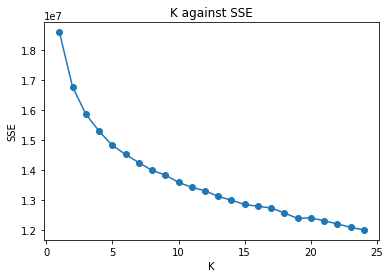

In [271]:
plt.plot(kMeans, sse, linestyle='-', marker='o')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('K against SSE')

print("Run time: %s min" % np.round(((time.time() - startTime)/60),2))

In [272]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kMeans = KMeans(n_clusters = 8)
model= kMeans.fit(pcaFeatures)
clusterPred = model.predict(pcaFeatures)

### Discussion 3.1: Apply Clustering to General Population

I first tried to run the KMeans clustering on the pcaFeatures dataset. The calculation did not stop after 3 hours. I therefore decided to create a random subset of the pcaFeatures. The first KMeans clustering included a center range from 1-15 and was finished after 4.95 min. The plot did not reveal a clear elbow - up to 4 clusters the curve runs very sharp and then gets steadily flatter, without a clear turnpoint but > 8 clusters did not reduce SSE very much anymore.  I repeated the KMeans clustering with a center range from 1-25, to check whether an elbow shows up clearly with a broader center range. The plot showed a similar picture. I therefore decided to segment the population into 8 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [273]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

In [274]:
customers.head()
customers.info()
customers.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

(191652, 85)

In [280]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#clean the data with the cleaning function
customersClean= clean_data(customers)

In [281]:
customersClean.head()
customersClean.info()
customersClean.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141725 entries, 0 to 191651
Columns: 191 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFESTAGE
dtypes: float64(44), int64(20), uint8(127)
memory usage: 87.4 MB


(141725, 191)

The cleaned customer dataset contains with 192 columns one column less compared to the cleaned azidas dataset.

In [282]:
#compare the columns with the azdias dataset to view which column is missing

list(set(azdiasNan.columns) - set(customersClean.columns))

['GEBAEUDETYP_5.0']

In contrast to the azdias dataset, no value =5.0 for the feature "GEBAUDETYP" exists in the customer dataset. To get the same amount of columns, we will add a column for GEBAUDETYP_5, setting the values to 0 (= "FALSE"/ One-hot encoding).

In [283]:
#add column GEBAEUDETYP_5.0 with default = 0(one-hot coded =false)
customersClean['GEBAEUDETYP_5.0']= 0 

In [293]:
#apply Imputation
customersImputed = imputer.fit_transform(customersClean)
#apply Scaling
scaledCustomer = scaler.fit_transform(customersImputed)
#apply PCA 
pcaCustomer = pca.fit_transform(scaledCustomer)
#apply kMeans
kMeansCustomers = model.predict(pcaCustomer)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5, 1.0, 'Population dataset cluster')

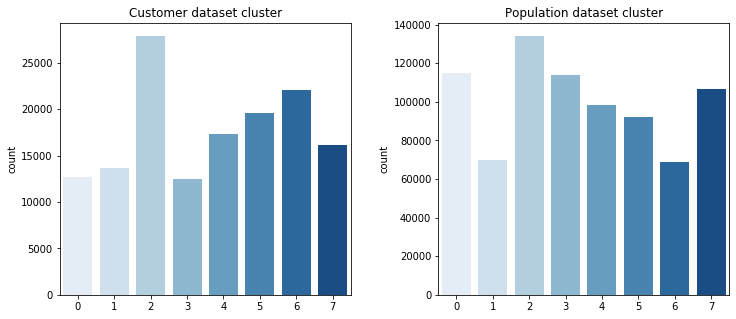

In [292]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (12,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(kMeansCustomers, ax=axs[0] ,palette="Blues")
axs[0].set_title('Customer dataset cluster')
sns.countplot(clusterPred, ax=axs[1], palette="Blues")
axs[1].set_title('Population dataset cluster')

Comparing the proportion of the customer dataset with the population dataset, the customer dataset contains comparable more data in cluster 6 and less data in cluster 0, 3, 4, 7.

In [403]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
pd.set_option('display.max_rows', 192)
centroid6=scaler.inverse_transform(pca.inverse_transform(kMeans.cluster_centers_[6])).round(1)
clusterPopular=pd.Series(data=centroid6,
                            index= customersClean.columns)
clusterPopular

ALTERSKATEGORIE_GROB            4.1
ANREDE_KZ                       0.8
FINANZ_MINIMALIST               5.2
FINANZ_SPARER                   0.6
FINANZ_VORSORGER                5.4
FINANZ_ANLEGER                  0.3
FINANZ_UNAUFFAELLIGER           1.4
FINANZ_HAUSBAUER                2.5
GREEN_AVANTGARDE                1.9
HEALTH_TYP                      1.4
RETOURTYP_BK_S                  4.7
SEMIO_SOZ                       5.3
SEMIO_FAM                       4.9
SEMIO_REL                       3.4
SEMIO_MAT                       4.3
SEMIO_VERT                      7.3
SEMIO_LUST                      6.7
SEMIO_ERL                       3.5
SEMIO_KULT                      5.1
SEMIO_RAT                       1.6
SEMIO_KRIT                      2.0
SEMIO_DOM                       2.3
SEMIO_KAEM                      1.3
SEMIO_PFLICHT                   2.0
SEMIO_TRADV                     2.6
SOHO_KZ                         1.0
VERS_TYP                        1.2
ANZ_PERSONEN                

In [392]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid0=scaler.inverse_transform(pca.inverse_transform(kMeans.cluster_centers_[0])).round(2)

unPopular0=pd.Series(data=centroid0,
                            index= customersClean.columns)
unPopular0


ALTERSKATEGORIE_GROB            2.92
ANREDE_KZ                       1.15
FINANZ_MINIMALIST               3.69
FINANZ_SPARER                   2.22
FINANZ_VORSORGER                3.78
FINANZ_ANLEGER                  2.14
FINANZ_UNAUFFAELLIGER           2.42
FINANZ_HAUSBAUER                2.67
GREEN_AVANTGARDE                1.34
HEALTH_TYP                      2.37
RETOURTYP_BK_S                  3.80
SEMIO_SOZ                       4.90
SEMIO_FAM                       4.88
SEMIO_REL                       4.15
SEMIO_MAT                       3.97
SEMIO_VERT                      5.55
SEMIO_LUST                      4.54
SEMIO_ERL                       4.05
SEMIO_KULT                      5.08
SEMIO_RAT                       3.41
SEMIO_KRIT                      3.46
SEMIO_DOM                       3.97
SEMIO_KAEM                      3.36
SEMIO_PFLICHT                   3.90
SEMIO_TRADV                     3.63
SOHO_KZ                         1.01
VERS_TYP                        1.62
A

In [400]:
centroid3=scaler.inverse_transform(pca.inverse_transform(kMeans.cluster_centers_[3])).round(2)

unPopular3=pd.Series(data=centroid3,
                            index= customersClean.columns)
unPopular3

ALTERSKATEGORIE_GROB            3.02
ANREDE_KZ                       1.77
FINANZ_MINIMALIST               3.43
FINANZ_SPARER                   2.24
FINANZ_VORSORGER                3.80
FINANZ_ANLEGER                  2.77
FINANZ_UNAUFFAELLIGER           2.41
FINANZ_HAUSBAUER                2.80
GREEN_AVANTGARDE                1.03
HEALTH_TYP                      2.36
RETOURTYP_BK_S                  3.31
SEMIO_SOZ                       3.38
SEMIO_FAM                       3.08
SEMIO_REL                       2.94
SEMIO_MAT                       2.76
SEMIO_VERT                      3.51
SEMIO_LUST                      4.41
SEMIO_ERL                       5.96
SEMIO_KULT                      2.94
SEMIO_RAT                       3.94
SEMIO_KRIT                      5.40
SEMIO_DOM                       5.29
SEMIO_KAEM                      5.51
SEMIO_PFLICHT                   3.84
SEMIO_TRADV                     3.21
SOHO_KZ                         1.01
VERS_TYP                        1.62
A

In [402]:
centroid7=scaler.inverse_transform(pca.inverse_transform(kMeans.cluster_centers_[7])).round(2)

unPopular7=pd.Series(data=centroid7,
                            index= customersClean.columns)
unPopular7

ALTERSKATEGORIE_GROB            3.01
ANREDE_KZ                       1.39
FINANZ_MINIMALIST               5.02
FINANZ_SPARER                   1.65
FINANZ_VORSORGER                4.29
FINANZ_ANLEGER                  1.79
FINANZ_UNAUFFAELLIGER           2.33
FINANZ_HAUSBAUER                1.50
GREEN_AVANTGARDE                2.16
HEALTH_TYP                      2.31
RETOURTYP_BK_S                  3.52
SEMIO_SOZ                       4.30
SEMIO_FAM                       3.72
SEMIO_REL                       3.60
SEMIO_MAT                       3.69
SEMIO_VERT                      4.90
SEMIO_LUST                      4.82
SEMIO_ERL                       4.58
SEMIO_KULT                      4.10
SEMIO_RAT                       3.74
SEMIO_KRIT                      4.10
SEMIO_DOM                       4.79
SEMIO_KAEM                      3.89
SEMIO_PFLICHT                   3.72
SEMIO_TRADV                     3.79
SOHO_KZ                         1.01
VERS_TYP                        1.68
A

In [290]:
print(feat_Dict)

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

### Discussion 3.3: Compare Customer Data to Demographics Data

The cluster proportion comparision indicates that people of the financial mid-sector, who are independent workers, live in multi-generation family holder-households are more popular with the company than young and mobile people / urban parents, having especially noticeable interests (e.g. cultural, religion, event travelling, sustainability). 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.